# Проект для интернет-магазина по определению негативных комментариев

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Надо обучить модель классифицировать комментарии на позитивные и негативные. В моем распоряжении набор данных с разметкой о токсичности правок.

Задача &mdash; построить модель со значением метрики качества *F1* не меньше 0.75.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
import re
import warnings
import numpy as np
import torch
import transformers
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tqdm import notebook

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
#def lemmas(text):
#    lemmas = ' '.join(re.sub(r'[^a-zA-z]', ' ', text).lower().split())
#    words = nltk.word_tokenize(lemmas)
#    lemmatized = ' '.join([lemmatizer.lemmatize(w) for w in words])    
#    return lemmatized

def lemmas(text):
    lemmas = nlp(" ".join(re.sub(r'[^a-zA-z]', ' ', text).split()))
    lemmatized = ' '.join([w.lemma_ for w in lemmas])
    return lemmatized

def pie_diag(df, i):
    plt.figure
    df1 = df.groupby(i)[i].count().sort_values(ascending=False)
    labels = df1.index
    n = len(labels)
    colors = sns.color_palette('pastel')[0:n]
    plt.pie(df1, labels=labels, colors = colors, autopct='%1.1f%%')

In [4]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [5]:
df = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [6]:
df.shape

(159292, 2)

In [7]:
display(df.isnull().sum())
print()
display(df[df.duplicated()])

text     0
toxic    0
dtype: int64

,text,toxic


In [8]:
lemmatizer = WordNetLemmatizer()

df['lemm_text'] = df['text'].apply(lemmas)

In [9]:
df.head()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edit make under my usernam...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour I m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man I m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...


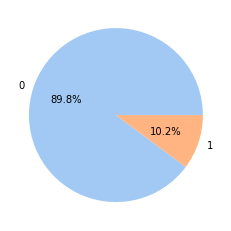

In [10]:
pie_diag(df, 'toxic')

Есть дисбаланс классов. Сначала построю модель, может быть, не придется его убирать.

In [11]:
X = df.drop(columns=['toxic'])
y = df['toxic']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y)

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y_train)

In [13]:
nltk.download('stopwords')
stop_words = list(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
corpus = X_train['lemm_text']

count_tf_idf = TfidfVectorizer(stop_words=stop_words)

X_train = count_tf_idf.fit_transform(corpus)

In [15]:
corpus = X_valid['lemm_text']

X_valid = count_tf_idf.transform(corpus)

## Обучение

In [16]:
model_lgbm = LGBMClassifier()

model_lgbm.fit(X_train, y_train)

LGBMClassifier()

In [17]:
lgbm_preds = model_lgbm.predict(X_valid)

In [18]:
print(f'Метрика F1 на валидационной выборке равна {f1_score(y_valid, lgbm_preds)}')

Метрика F1 на валидационной выборке равна 0.7452266152362584


Почти. Я пробовал сделать RandomizedSearchCV для lgbm, но это оказалось очень долгим процессом. С матрицами, где много столбцов, хорошо работают линейные модели. Попробую сделать пайплайн для LogisticRegression.

In [19]:
warnings.filterwarnings('ignore')

model_lr = LogisticRegression(random_state=RANDOM_STATE)

C = [0.08, 0.16, 0.32, 0.64, 1.28, 2.56, 5.12, 10.24]

param_grid = dict(C=C)

grid_search_lr = GridSearchCV(
    model_lr,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
grid_search_lr.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.08, 0.16, 0.32, 0.64, 1.28, 2.56, 5.12,
                               10.24]},
             scoring='f1')

In [20]:
lr_preds = grid_search_lr.predict(X_valid)

In [21]:
print('Лучшая модель и её параметры:\n\n', grid_search_lr.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid_search_lr.best_score_)

print(f'Метрика F1 на валидационной выборке равна {f1_score(y_valid, lr_preds)}')

Лучшая модель и её параметры:

 LogisticRegression(C=10.24, random_state=42)
Метрика лучшей модели на тренировочной выборке: 0.7647547657266083
Метрика F1 на валидационной выборке равна 0.770027752081406


In [22]:
corpus = X_test['lemm_text']

X_test = count_tf_idf.transform(corpus)

In [23]:
lr_preds = grid_search_lr.predict(X_test)
print(f'Метрика F1 на валидационной выборке равна {f1_score(y_test, lr_preds)}')

Метрика F1 на валидационной выборке равна 0.77081880318036


## Выводы

Метрика f1 выше 0.75, задача выполнена. Что было сделано? Лемматизированы все строки датасета, приведены в векторный вид, построена матрица. На ее основе модель научилась предсказывать ткосичность комментариев.